# Feature Extraction

In [2]:
!pip install spacy
!pip install razdel
!pip install nltk
!python -m spacy download ru_core_news_lg
!pip install gensim
!pip install sentence-transformers
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 105.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 91.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
from sentence_transformers import SentenceTransformer

In [4]:
import re
import math
import json
import string
import numpy as np
from collections import Counter
from typing import List, Dict

import spacy
from razdel import tokenize, sentenize
import ru_core_news_lg
from gensim import corpora, models
from sentence_transformers import SentenceTransformer

In [5]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
nlp = ru_core_news_lg.load()
VOWELS = "аеёиоуыэюя"

In [8]:
class BaseFeatureExtractor:
    """
    Базовый абстрактный класс для всех извлекателей признаков
    """

    def extract(self, text: str) -> Dict:
        # Основной метод извлечения признаков
        raise NotImplementedError

    def get_tokens(self, text: str) -> List[str]:
        # Получение списка слов
        return [t.text.lower() for t in tokenize(text) if t.text.isalpha()]

    def get_sentences(self, text: str) -> List[str]:
        # Разбиение текста на предложения
        return [s.text for s in sentenize(text)]

    def count_syllables(self, word: str) -> int:
        # Подсчёт количества слогов в слове
        return sum(1 for ch in word.lower() if ch in VOWELS)

In [9]:
class ReadabilityFeatures(BaseFeatureExtractor):

    """
    Индексы читабельности
    """

    #  Flesch–Kincaid readability index
    def flesch_kincaid(self, text):
        words = self.get_tokens(text)
        sents = self.get_sentences(text)

        if not words or not sents:
            return 0

        syllables = sum(self.count_syllables(w) for w in words)
        ASL = len(words) / len(sents)
        ASW = syllables / len(words)

        return 0.5 * ASL + 8.4 * ASW - 15.59

    # Coleman–Liau index
    def coleman_liau(self, text):
        words = self.get_tokens(text)
        sents = self.get_sentences(text)

        if not words:
            return 0

        chars = sum(len(w) for w in words)
        L = (chars / len(words)) * 100
        S = (len(sents) / len(words)) * 100

        return 0.055 * L - 0.35 * S - 20.33

    # Automated Readability Index
    def ari(self, text):
        words = self.get_tokens(text)
        sents = self.get_sentences(text)

        if not words or not sents:
            return 0

        chars = sum(len(w) for w in words)

        return 6.26 * (chars / len(words)) + 0.2805 * (len(words) / len(sents)) - 31.04

    # SMOG grade
    def smog(self, text):
        words = self.get_tokens(text)
        sents = self.get_sentences(text)

        if not sents:
            return 0

        polysyll = sum(1 for w in words if self.count_syllables(w) >= 3)

        return 1.1 * math.sqrt(polysyll * (64.6 / len(sents))) + 0.05


    def extract(self, text):
        return {
        "flesch_kincaid": self.flesch_kincaid(text),
        "ari": self.ari(text),
        "coleman_liau": self.coleman_liau(text),
        "smog": self.smog(text),
        }

In [10]:
class TraditionalFeatures(BaseFeatureExtractor):

    """
    Базовые  признаки
    """

    def extract(self, text):
        tokens = self.get_tokens(text)
        sents = self.get_sentences(text)

        sent_lens = [len(self.get_tokens(s)) for s in sents]
        word_lens = [len(w) for w in tokens]

        vocab = set(tokens)

        long_words = [w for w in tokens if self.count_syllables(w) > 4]

        doc = nlp(text)

        nouns = [t.text for t in doc if t.pos_ == "NOUN"]
        adjs = [t.text for t in doc if t.pos_ == "ADJ"]
        verbs = [t.text for t in doc if t.pos_ == "VERB"]

        # Type/token ratio
        def ttr(lst):
            return len(set(lst)) / max(1, len(lst))

        # NAV: TTR for Nouns only plus TTR for Adjectives only divided by
        # TTR for Verbs only
        nav = (ttr(nouns) + ttr(adjs)) / max(1e-5, ttr(verbs))

        return {
            "avg_sent_len": np.mean(sent_lens) if sent_lens else 0,
            "med_sent_len": np.median(sent_lens) if sent_lens else 0,
            "avg_word_len": np.mean(word_lens) if word_lens else 0,
            "med_word_len": np.median(word_lens) if word_lens else 0,
            "long_word_ratio": len(long_words) / max(1, len(tokens)),
            "ttr": len(vocab) / max(1, len(tokens)),
            "nav_ratio": nav,
            }

In [11]:
class MorphologicalFeatures(BaseFeatureExtractor):

    """
    Морфологические признаки
    """

    def extract(self, text):
        doc = nlp(text)

        pos_counts = Counter()
        cases = Counter()
        aspects = Counter()
        tenses = Counter()
        voices = Counter()
        animacy = Counter()
        participles = 0
        gerunds = 0

        total = 0

        for t in doc:
            if not t.is_alpha:
                continue

            total += 1
            pos_counts[t.pos_] += 1

            morph = t.morph

            # Падеж
            if "Case" in morph:
                cases[morph.get("Case")[0]] += 1
            # Вид
            if "Aspect" in morph:
                aspects[morph.get("Aspect")[0]] += 1

            # Время
            if "Tense" in morph:
                tenses[morph.get("Tense")[0]] += 1

            # Залог
            if "Voice" in morph:
                voices[morph.get("Voice")[0]] += 1

            # Одушевленность
            if "Animacy" in morph:
                animacy[morph.get("Animacy")[0]] += 1

            # Причастия
            if "VerbForm=Part" in str(morph):
                participles += 1

            # Деепричастия
            if "VerbForm=Conv" in str(morph):
                gerunds += 1

        feats = {}
        total = max(1, total)

        for k, v in pos_counts.items():
            feats[f"pos_{k}"] = v / max(1, total)

        for k, v in cases.items():
            feats[f"case_{k}"] = v / max(1, total)

        for k, v in aspects.items():
            feats[f"aspect_{k}"] = v / max(1, total)

        for k, v in tenses.items():
            feats[f"tense_{k}"] = v / max(1, total)

        for k, v in voices.items():
            feats[f"voice_{k}"] = v / max(1, total)

        for k, v in animacy.items():
            feats[f"animacy_{k}"] = v / max(1, total)

        feats["participle_ratio"] = participles / total
        feats["gerund_ratio"] = gerunds / total

        return feats

In [12]:
class PunctuationFeatures(BaseFeatureExtractor):
    """
    Пунктуационные признаки
    """
    def extract(self, text):
        tokens = list(tokenize(text))
        total = len(tokens)

        punct = [t.text for t in tokens if t.text in string.punctuation]
        semicolons = [p for p in punct if p == ";"]

        return {
        "punct_ratio": len(punct) / max(1, total),
        "semicolon_ratio": len(semicolons) / max(1, total),
        }

In [13]:
class SyntacticFeatures(BaseFeatureExtractor):
    """
    Синтаксические признаки
    """

    def extract(self, text):
        doc = nlp(text)

        depths = []             # syntactic tree depth
        dep_dists = []          # distance between a node and its descendant

        clauses = 0
        advcl = 0               # adverbial clause modifiers
        acl = 0                 # adnominal clauses
        ccomp = 0               # clausal complements
        xcomp = 0               # open clausal complements
        nominal_modifiers = 0
        max_nominal_chain = 0



In [14]:
class SyntacticFeatures(BaseFeatureExtractor):

    """
    Синтаксические признаки
    """

    def extract(self, text):
        doc = nlp(text)

        tree_depths = []          # глубина деревьев
        dependency_distances = []  # расстояния head-token

        clause_counts = {
            "ccomp": 0,             # clausal complements
            "xcomp": 0,             # open clausal complements
            "advcl": 0,             # adverbial clause modifiers
            "acl": 0                # adnominal clauses
        }

        nominal_modifiers = 0
        max_nominal_chain = 0

        sent_count = 0

        def get_depth(token):
            """
            Рекурсивно считает глубину поддерева
            """

            if not list(token.children):
                return 1

            return 1 + max(get_depth(child) for child in token.children)

        for sent in doc.sents:
            sent_count += 1
            roots = [t for t in sent if t.head == t]

            if roots:
                depth = max(get_depth(root) for root in roots)
                tree_depths.append(depth)

            for t in sent:
                # Расстояние в дереве
                if t.head != t:
                    dist = abs(t.i - t.head.i)
                    dependency_distances.append(dist)

                # Клаузы
                if t.dep_ in clause_counts:
                    clause_counts[t.dep_] += 1

                # Именные группы
                if t.pos_ == "NOUN":

                    modifiers = []

                    for child in t.children:
                        if child.dep_ in {
                            "amod",
                            "nmod",
                            "acl",
                            "det",
                            "nummod",
                            "compound"
                        }:
                            modifiers.append(child)

                    nominal_modifiers += len(modifiers)

                    # Цепочки модификаторов
                    for m in modifiers:
                        length = 1
                        current = m

                        while True:
                            next_mod = None

                            for ch in current.children:

                                if ch.dep_ in {
                                    "amod",
                                    "nmod",
                                    "compound"
                                }:
                                    next_mod = ch
                                    break

                            if next_mod:
                                length += 1
                                current = next_mod
                            else:
                                break

                        max_nominal_chain = max(
                            max_nominal_chain,
                            length
                        )

        feats = {}

        # Глубина дерева
        feats["tree_depth_mean"] = np.mean(tree_depths) if tree_depths else 0
        feats["tree_depth_median"] = np.median(tree_depths) if tree_depths else 0
        feats["tree_depth_max"] = max(tree_depths) if tree_depths else 0

        # Расстояния зависимостей
        feats["dep_dist_mean"] = np.mean(dependency_distances) if dependency_distances else 0
        feats["dep_dist_median"] = np.median(dependency_distances) if dependency_distances else 0
        feats["dep_dist_max"] = max(dependency_distances) if dependency_distances else 0

        # Клаузы
        for k, v in clause_counts.items():
            feats[f"clause_{k}"] = v

        feats["clause_total"] = sum(clause_counts.values())

        # Именные модификаторы
        feats["nominal_modifiers_count"] = nominal_modifiers
        feats["max_nominal_chain"] = max_nominal_chain

        # Нормализация по предложениям
        feats["sent_count"] = sent_count

        if sent_count > 0:
            feats["nominal_modifiers_per_sent"] = (
                nominal_modifiers / sent_count
            )

            feats["clauses_per_sent"] = (
                feats["clause_total"] / sent_count
            )

        else:
            feats["nominal_modifiers_per_sent"] = 0
            feats["clauses_per_sent"] = 0

        return feats

In [15]:
class NERFeatures(BaseFeatureExtractor):
    """
    Именованные сущности
    """
    def extract(self, text):

        doc = nlp(text)

        ents = Counter(ent.label_ for ent in doc.ents)
        total = sum(ents.values())

        feats = {}

        #  Именнованные сущности по типам
        for k, v in ents.items():
            feats[f"ner_{k}"] = v / max(1, total)

        feats["ner_total"] = total

        return feats

In [16]:
class LDAFeatures(BaseFeatureExtractor):
    """
    Тематические признаки LDA
    """

    def __init__(self, num_topics=100):
        self.num_topics = num_topics
        self.lda = None
        self.dictionary = None


    def fit(self, texts: List[str]):
        tokenized = [self.get_tokens(t) for t in texts]

        self.dictionary = corpora.Dictionary(tokenized)
        corpus = [self.dictionary.doc2bow(t) for t in tokenized]

        self.lda = models.LdaModel(
            corpus,
            num_topics=self.num_topics,
            id2word=self.dictionary,
            passes=10
            )

    def extract(self, text):
        if self.lda is None:
            raise ValueError()

        bow = self.dictionary.doc2bow(self.get_tokens(text))
        topics = self.lda.get_document_topics(bow)
        vec = np.zeros(self.num_topics)
        for i, w in topics:
            vec[i] = w

        return {f"topic_{i}": vec[i] for i in range(self.num_topics)}

In [17]:
class EmbeddingFeaturesWithPCA(BaseFeatureExtractor):
    """
    Класс для эмбеддингов с PCA уменьшением размерности
    """

    def __init__(self,
                 model_name='cointegrated/rubert-tiny2',
                 n_components=128):

        super().__init__()

        self.model = SentenceTransformer(model_name)
        self.original_dim = self.model.get_sentence_embedding_dimension()
        self.n_components = n_components

        self.pca = PCA(n_components=n_components)
        self.pca_fitted = False

    def fit_pca(self, texts: list):

        # Получаем эмбеддинги для всех текстов
        embeddings = []
        batch_size = 32

        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            batch_embeddings = self.model.encode(
                batch,
                convert_to_tensor=False,
                show_progress_bar=False
            )
            embeddings.append(batch_embeddings)

        # Объединяем все эмбеддинги
        embeddings = np.vstack(embeddings)

        # Обучаем PCA
        self.pca.fit(embeddings)
        self.pca_fitted = True


    def extract(self, text: str) -> Dict:
        # Получаем оригинальный эмбеддинг
        embedding = self.model.encode(
            text,
            convert_to_tensor=False,
            show_progress_bar=False
        )

        # Применяем PCA, если он обучен
        if self.pca_fitted:
            embedding = self.pca.transform(embedding.reshape(1, -1)).flatten()
        else:
            embedding = embedding[:self.n_components]

        features = {}
        for i in range(len(embedding)):
            features[f"emb_pca_{i}"] = float(embedding[i])

        return features

In [18]:
class FeaturePipeline:
    """
    Конвейер признаков
    """
    def __init__(self, extractors: List[BaseFeatureExtractor]):
        self.extractors = extractors

    def extract(self, text: str) -> Dict:
        features = {}
        for ext in self.extractors:
            features.update(ext.extract(text))
        return features

    def extract_batch(self, texts: List[str], batch_size: int = 64) -> pd.DataFrame:
        all_features = []

        for i in tqdm(range(0, len(texts), batch_size), desc="Извлечение признаков"):
            batch = texts[i:i+batch_size]
            batch_features = []

            for text in batch:
                feats = self.extract(str(text))
                batch_features.append(feats)

            all_features.extend(batch_features)

        features_df = pd.DataFrame(all_features)

        features_df = features_df.fillna(0)

        return features_df

In [19]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')
val_df = pd.read_csv('val_dataset.csv')

all_texts = pd.concat([train_df['text'], test_df['text'], val_df['text']]).reset_index(drop=True)
all_texts_df = pd.DataFrame({'text': all_texts})

In [20]:
n_train = len(train_df)
n_test = len(test_df)
n_val = len(val_df)

In [21]:
# Инициализация LDA
lda_extractor = LDAFeatures(num_topics=30)
lda_extractor.fit(all_texts_df['text'].tolist())

In [22]:
# Инициализация эмбеддингов
emb_extractor = EmbeddingFeaturesWithPCA()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [23]:
# Создание пайплайна
pipeline = FeaturePipeline([
    ReadabilityFeatures(),
    TraditionalFeatures(),
    MorphologicalFeatures(),
    PunctuationFeatures(),
    NERFeatures(),
    SyntacticFeatures(),
    lda_extractor,
    emb_extractor
])

In [24]:
all_features = pipeline.extract_batch(all_texts_df['text'].tolist(), batch_size=64)

Извлечение признаков:   0%|          | 0/414 [00:00<?, ?it/s]

In [25]:
X_train = all_features.iloc[:n_train].reset_index(drop=True)
X_test = all_features.iloc[n_train:n_train+n_test].reset_index(drop=True)
X_val = all_features.iloc[n_train+n_test:n_train+n_test+n_val].reset_index(drop=True)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"X_val: {X_val.shape}")

X_train: (21163, 209)
X_test: (2645, 209)
X_val: (2646, 209)


In [26]:
le = LabelEncoder()
y_train_enc = le.fit_transform(train_df['cefr_level'])
y_test_enc = le.transform(test_df['cefr_level'])
y_val_enc = le.transform(val_df['cefr_level'])

# Deep Learning

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
# масштабируем входные данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)
X_val_scaled = scaler.transform(X_val.values)

In [56]:
# приводим к тензорам
X_train_tensor = torch.FloatTensor(X_train_scaled.astype(np.float32))
X_test_tensor = torch.FloatTensor(X_test_scaled.astype(np.float32))
X_val_tensor = torch.FloatTensor(X_val_scaled.astype(np.float32))

y_train_tensor = torch.LongTensor(y_train_enc.astype(np.int64))
y_test_tensor = torch.LongTensor(y_test_enc.astype(np.int64))
y_val_tensor = torch.LongTensor(y_val_enc.astype(np.int64))

In [44]:
# создаём датасеты и даталоадеры
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [80]:
# класс нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes=1):
        super(NeuralNetwork, self).__init__()

        # прописываем все слои: комбинация полносвязных-батчнормов и дропаутов
        # функция активации -- релу
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.1)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)

        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)

        self.fc6 = nn.Linear(32, num_classes)
        self.output_activation = nn.Identity()

        self.relu = nn.ReLU()

    def forward(self, x):
        # прописываем всю последовательность
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        x = self.output_activation(x)
        return x

In [82]:
def calculate_accuracy(outputs, labels):
    '''
    Функция для вычисления accuracy по выходу модели и реальным меткам.
    '''
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [84]:
# инициализируем модель
input_size = X_train_tensor.shape[1]
num_classes = len(le.classes_)
model = NeuralNetwork(input_size, num_classes).to(device)

# функция потерь, оптимизатор и шедулер
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# количество эпох
num_epochs = 100

# здесь будем хранить лоссы и accuracy во время обучения
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# чтобы определить лучшую модель (будем сравнивать с этим значением)
best_val_loss = float('inf')
best_model_state = None

# начинаем обучение
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    batch_count = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # добавляем лосс, аккьюраси
        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, labels)
        batch_count += 1

    # сохраняем средние значения метрик за одну эпоху
    train_loss = running_loss / batch_count
    train_accuracy = running_accuracy / batch_count
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # смотрим на валидацию
    model.eval()
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    val_batch_count = 0

    # считаем лосс и аккьюраси на валидации на этой же эпохе
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            val_running_accuracy += calculate_accuracy(outputs, labels)
            val_batch_count += 1

    val_loss = val_running_loss / val_batch_count
    val_accuracy = val_running_accuracy / val_batch_count
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # шаг шедулера
    scheduler.step(val_loss)

    # если на валидации лосс лучше, чем был до этого, считаем, что лучшая модель
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        torch.save(model.state_dict(), 'best_model.pth')

    # каждые пять эпох выводим статистику
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

Epoch [5/100], Train Loss: 1.2036, Train Acc: 0.53, Val Loss: 1.1832, Val Acc: 0.53, LR: 0.001000
Epoch [10/100], Train Loss: 1.0915, Train Acc: 0.57, Val Loss: 1.1408, Val Acc: 0.55, LR: 0.001000
Epoch [15/100], Train Loss: 1.0307, Train Acc: 0.60, Val Loss: 1.1268, Val Acc: 0.56, LR: 0.001000
Epoch [20/100], Train Loss: 0.9763, Train Acc: 0.62, Val Loss: 1.1273, Val Acc: 0.57, LR: 0.000500
Epoch [25/100], Train Loss: 0.8956, Train Acc: 0.65, Val Loss: 1.1234, Val Acc: 0.57, LR: 0.000500
Epoch [30/100], Train Loss: 0.8544, Train Acc: 0.67, Val Loss: 1.1439, Val Acc: 0.58, LR: 0.000250
Epoch [35/100], Train Loss: 0.8302, Train Acc: 0.68, Val Loss: 1.1402, Val Acc: 0.57, LR: 0.000125
Epoch [40/100], Train Loss: 0.8193, Train Acc: 0.69, Val Loss: 1.1465, Val Acc: 0.58, LR: 0.000063
Epoch [45/100], Train Loss: 0.8116, Train Acc: 0.68, Val Loss: 1.1463, Val Acc: 0.58, LR: 0.000031
Epoch [50/100], Train Loss: 0.8031, Train Acc: 0.69, Val Loss: 1.1524, Val Acc: 0.57, LR: 0.000016
Epoch [55/1

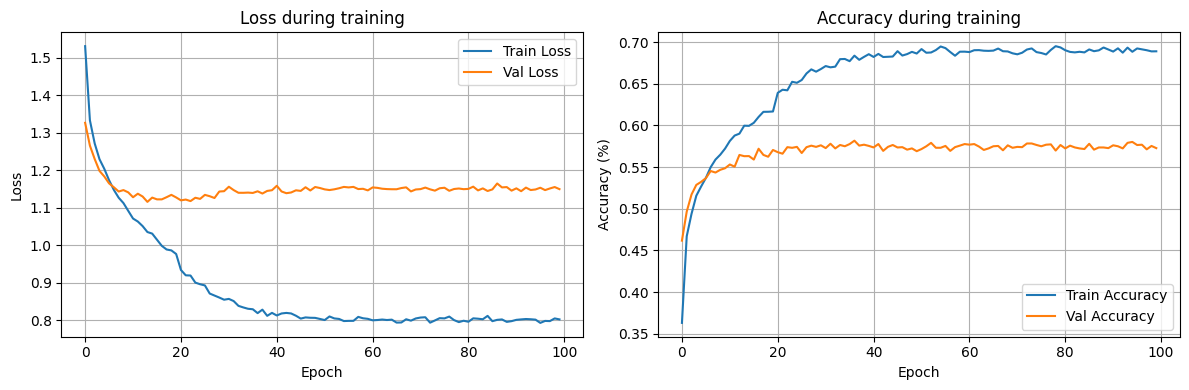

In [86]:
# кривые обучения для лосса и accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during training')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [89]:
def predict(model, dataloader):
    '''
    Функция для предсказания на новых данных.
    Возвращает predictions, probabilities, labels.
    '''
    # загружаем лучшую модель и переводим в режим валидации
    model.load_state_dict(best_model_state)
    model.eval()

    # здесь будем хранить данные
    all_predictions = []
    all_probabilities = []
    all_labels = []

    # получаем предсказания модели
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            outputs = model(inputs)

            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            predictions = np.argmax(probabilities, axis=1)

            all_predictions.extend(predictions)
            all_probabilities.extend(probabilities)
            all_labels.extend(labels.cpu().numpy())

    # преобразуем в numpy массивы
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)

    return all_predictions, all_probabilities, all_labels

In [90]:
predictions, probabilities, labels = predict(model, test_loader)
print(f'''Accuracy: {accuracy_score(labels, predictions)}
F1: {f1_score(labels, predictions, average='macro')}''')

Accuracy: 0.5606805293005671
F1: 0.5584583571518293
